# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# Algumas configurações para o matplotlib.
#%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

In [6]:
df = pd.read_csv("countries.csv")

In [7]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

df.columns = new_column_names

df.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

In [8]:
# Substituindo ',' por '.' e mudando as colunas para o tipo float
df['Pop_density'] = df['Pop_density'].str.replace(',', '.').astype(float)
df['Coastline_ratio'] = df['Coastline_ratio'].str.replace(',', '.').astype(float)
df['Net_migration'] = df['Net_migration'].str.replace(',', '.').astype(float)
df['Infant_mortality'] = df['Infant_mortality'].str.replace(',', '.').astype(float)
df['Literacy'] = df['Literacy'].str.replace(',', '.').astype(float)
df['Phones_per_1000'] = df['Phones_per_1000'].str.replace(',', '.').astype(float)
df['Arable'] = df['Arable'].str.replace(',', '.').astype(float)
df['Crops'] = df['Crops'].str.replace(',', '.').astype(float)
df['Other'] = df['Other'].str.replace(',', '.').astype(float)
df['Climate'] = df['Climate'].str.replace(',', '.').astype(float)
df['Birthrate'] = df['Birthrate'].str.replace(',', '.').astype(float)
df['Deathrate'] = df['Deathrate'].str.replace(',', '.').astype(float)
df['Agriculture'] = df['Agriculture'].str.replace(',', '.').astype(float)
df['Industry'] = df['Industry'].str.replace(',', '.').astype(float)
df['Service'] = df['Service'].str.replace(',', '.').astype(float)

# Removendo os espaços no começo e final
df['Country'] = df['Country'].str.strip()
df['Region'] = df['Region'].str.strip()

## Inicia sua análise a partir daqui

In [9]:
df.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


In [10]:
df.describe()

,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
count,2.270000e+02,2.270000e+02,227.000000,227.000000,224.000000,224.000000,226.000000,209.000000,223.000000,225.000000,225.000000,225.000000,205.000000,224.000000,223.000000,212.000000,211.000000,212.000000
mean,2.874028e+07,5.982270e+05,379.047137,21.165330,0.038125,35.506964,9689.823009,82.838278,236.061435,13.797111,4.564222,81.638311,2.139024,22.114732,9.241345,0.150844,0.282711,0.565283
std,1.178913e+08,1.790282e+06,1660.185825,72.286863,4.889269,35.389899,10049.138513,19.722173,227.991829,13.040402,8.361470,16.140835,0.699397,11.176716,4.990026,0.146798,0.138272,0.165841
min,7.026000e+03,2.000000e+00,0.000000,0.000000,-20.990000,2.290000,500.000000,17.600000,0.200000,0.000000,0.000000,33.330000,1.000000,7.290000,2.290000,0.000000,0.020000,0.062000
25%,4.376240e+05,4.647500e+03,29.150000,0.100000,-0.927500,8.150000,1900.000000,70.600000,37.800000,3.220000,0.190000,71.650000,2.000000,12.672500,5.910000,0.037750,0.193000,0.429250
50%,4.786994e+06,8.660000e+04,78.800000,0.730000,0.000000,21.000000,5550.000000,92.500000,176.200000,10.420000,1.030000,85.700000,2.000000,18.790000,7.840000,0.099000,0.272000,0.571000
75%,1.749777e+07,4.418110e+05,190.150000,10.345000,0.997500,55.705000,15700.000000,98.000000,389.650000,20.000000,4.440000,95.440000,3.000000,29.820000,10.605000,0.221000,0.341000,0.678500
max,1.313974e+09,1.707520e+07,16271.500000,870.660000,23.060000,191.190000,55100.000000,100.000000,1035.600000,62.110000,50.680000,100.000000,4.000000,50.730000,29.740000,0.769000,0.906000,0.954000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country           227 non-null    object 
 1   Region            227 non-null    object 
 2   Population        227 non-null    int64  
 3   Area              227 non-null    int64  
 4   Pop_density       227 non-null    float64
 5   Coastline_ratio   227 non-null    float64
 6   Net_migration     224 non-null    float64
 7   Infant_mortality  224 non-null    float64
 8   GDP               226 non-null    float64
 9   Literacy          209 non-null    float64
 10  Phones_per_1000   223 non-null    float64
 11  Arable            225 non-null    float64
 12  Crops             225 non-null    float64
 13  Other             225 non-null    float64
 14  Climate           205 non-null    float64
 15  Birthrate         224 non-null    float64
 16  Deathrate         223 non-null    float64
 1

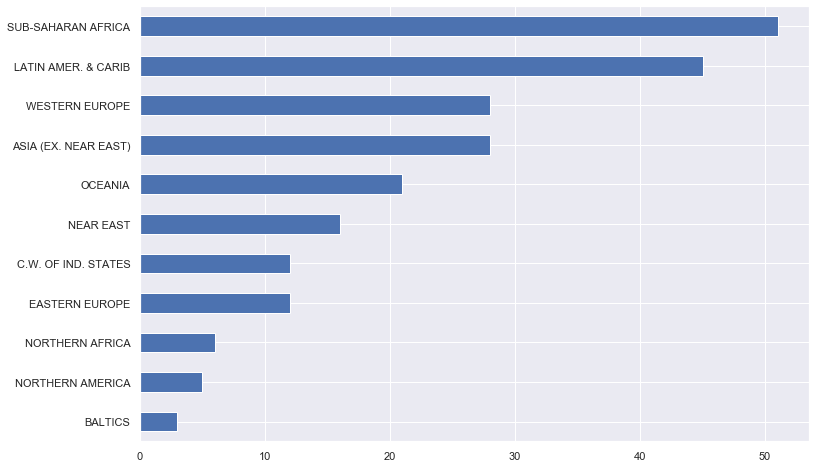

In [12]:
df.Region.value_counts(ascending=True).plot(kind='barh');

In [13]:
df.isna().sum()

Country              0
Region               0
Population           0
Area                 0
Pop_density          0
Coastline_ratio      0
Net_migration        3
Infant_mortality     3
GDP                  1
Literacy            18
Phones_per_1000      4
Arable               2
Crops                2
Other                2
Climate             22
Birthrate            3
Deathrate            4
Agriculture         15
Industry            16
Service             15
dtype: int64

## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [14]:
def q1():
    regions = df.Region.unique()
    return sorted(regions)
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [15]:
def q2():
    x = df['Pop_density'].values
    x = x.reshape(-1,1)
    kbd = KBinsDiscretizer(n_bins=10, 
                           encode='ordinal', 
                           strategy='quantile')
    kbd.fit(x)
    perc90 = np.percentile(x, 90)
    country = 0
    for i in x:
        if i > perc90:
            country +=1
    
    return country
q2()

23

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [18]:
def q3():
    
#     x = df.Climate.nunique(dropna=False)
#     y = df.Region.nunique(dropna=False)
#     one_hot = x + y
#     return one_hot
    one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)
    r_ohe = one_hot_encoder.fit_transform(df[['Region']])
    clim = df[['Climate']].fillna(df['Climate'].mean())
    c_ohe = one_hot_encoder.fit_transform(clim)
    n_atributos = r_ohe.shape[1] + c_ohe.shape[1]
    return (n_atributos)
    #return int(n_atributos)


q3()

18

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [14]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [15]:
# Arable index
df.columns.get_loc("Arable")

11

Each element from the list above represents a column from a dataframe.
Our column `Arable` has the index 11. But solving the problem we removed
two elements from our list so that's why was used transform[0][9]  

In [16]:
def q4():
    cols = df.select_dtypes(['int64', 'float64']).columns
    pipe = Pipeline(steps = [('imputer', 
                              SimpleImputer(strategy = 'median')),
                             ('scaler', 
                              StandardScaler())])
    pipe.fit(df[cols])
    transform = pipe.transform([test_country[2:]])
    arable = round(transform[0][9],3)
    return float (arable)

q4()

-1.047

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

In [17]:
def q5():
    Q1 = df.Net_migration.quantile(0.25)
    Q3 = df.Net_migration.quantile(0.75)
    IQR = Q3 - Q1

    low = int((df.Net_migration < (Q1 - 1.5 * IQR)).sum())
    up_ = int((df.Net_migration > (Q3 + 1.5 * IQR)).sum())
    remove_ = bool(False)

    return tuple((low, up_, remove_))
    
q5()

(24, 26, False)

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [18]:
categories = ['sci.electronics', 
              'comp.graphics', 
              'rec.motorcycles']

newsgroup = fetch_20newsgroups(subset="train",
                               shuffle=True,
                               categories=categories,  
                               random_state=42)

In [19]:
def q6():
    vector = CountVectorizer()
    train_ = vector.fit_transform(newsgroup.data)
    counts = pd.DataFrame(train_.toarray(),
                          columns=vector.get_feature_names())
    quant_ = counts['phone'].sum()
    return int(quant_)

q6()

213

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [20]:
def q7():
    vector = TfidfVectorizer()
    train_ =  vector.fit_transform(newsgroup.data)
    counts = pd.DataFrame(train_.toarray(),
                          columns = vector.get_feature_names())
    quanti = round(counts['phone'].sum(),3)
    return float(quanti)

q7()

8.888